In [1]:
import os, requests

# Store the raw files in this location.  These files
# can be deleted after the "prep.py" script is run.
tpath = "data"

# The file name template.
target = "%s/argo/raw/OOOO_ocean/YYYY/MM" % tpath

# Get the data from this web site
url = "https://data-argo.ifremer.fr/geo/OOOO_ocean/YYYY/MM/FF"

def getdata(ocean, year, month, day):

    fl = "%4d%02d%02d_prof.nc" % (year, month, day)
    url1 = url.replace("OOOO", ocean)
    url1 = url1.replace("YYYY", "%4d" % year)
    url1 = url1.replace("MM", "%02d" % month)
    url1 = url1.replace("DD", "%02d" % day)
    url1 = url1.replace("FF", fl)

    target1 = target.replace("OOOO", ocean)
    target1 = target1.replace("YYYY", "%4d" % year)
    target1 = target1.replace("MM", "%02d" % month)

    os.makedirs(target1, exist_ok=True)
    target1 = "%s/%s" % (target1, fl)
    response = requests.get(url1)
    open(target1, "wb").write(response.content)

def get_year(ocean, year):
    for month in range(1, 13):
        print("%s..." % month)
        if month in [4, 6, 9, 11]:
            days = 30
        elif month == 2:
            days = 29 if year % 4 == 0 else 28
        else:
            days = 31

        for day in range(1, days+1):
            print("%s." % day, end="", flush=True)
            getdata(ocean, year, month, day)
        print("")

get_year("pacific", 2020)

1...
1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.
2...
1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.
3...
1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.
4...
1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.
5...
1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.
6...
1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.
7...
1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.
8...
1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.
9...
1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.
10...
1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.
11...
1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.
12...
1.2.3.4.5.6.7.8.9.10

In [2]:
from pathlib import Path
import os, datetime
from scipy.interpolate import interp1d
from netCDF4 import Dataset
import numpy as np

# Path to the NetCDF files here, this path must be the same
# as 'tpath' in the get_data.py script.  After running
# prep.py, the contents of tpath can be deleted.
dpath = tpath / Path("argo/raw")

# Store the files produced by this script here.  This must
# agree with the path set in the 'read.py' script.
qpath = Path("data")
os.makedirs(qpath, exist_ok=True)

# Retain only profiles that span this range of pressures
minpress = 20
maxpress = 1500

# Interpolate all data onto this pressure grid
pressure = np.linspace(minpress, maxpress, 100)

def clean_range(x):
    mn = x.getncattr("valid_min")
    mx = x.getncattr("valid_max")
    z = np.asarray(x[:])
    z = np.where(z < mn, 9999, z)
    z = np.where(z > mx, 9999, z)
    return z

def get_raw(fn):
    ncf = Dataset(fn, "r")
    lat = ncf.variables["LATITUDE"]
    lon = ncf.variables["LONGITUDE"]
    pres = ncf.variables["PRES_ADJUSTED"]
    temp = ncf.variables["TEMP_ADJUSTED"]
    psal = ncf.variables["PSAL_ADJUSTED"]

    temp = clean_range(temp)
    psal = clean_range(psal)
    pres = clean_range(pres)

    return lat, lon, pres, temp, psal

def interp_profile(pres, temp, psal):
    ii = (pres != 9999) & (temp != 9999) & (psal != 9999)
    if sum(ii) < 100:
        return None, None

    pres = pres[ii]
    temp = temp[ii]
    psal = psal[ii]
    if pres.min() >= minpress or pres.max() <= maxpress:
        return None, None

    ii = np.argsort(pres)
    pres = pres[ii]
    temp = temp[ii]
    psal = psal[ii]

    temp1 = interp1d(pres, temp)(pressure)
    psal1 = interp1d(pres, psal)(pressure)

    return temp1, psal1

def get_profiles():

    nskip = 0
    lat, lon, pres, temp, psal, date = [], [], [], [], [], []

    for root, dirs, files in os.walk(dpath):
        for file in files:
            if not file.endswith(".nc"):
                continue

            year = int(file[0:4])
            month = int(file[4:6])
            day = int(file[6:8])
            print(file)

            dt = datetime.date(year, month, day)
            lat1, lon1, pres1, temp1, psal1 = get_raw(Path(root) / file)

            for j in range(pres1.shape[0]):
                temp2, psal2 = interp_profile(pres1[j, :], temp1[j, :], psal1[j, :])
                if temp2 is not None:
                    lat.append(lat1[j])
                    lon.append(lon1[j])
                    temp.append(temp2)
                    psal.append(psal2)
                    date.append(dt)
                else:
                    nskip += 1

    lat = np.asarray(lat)
    lon = np.asarray(lon)
    date = np.asarray(date)
    temp = np.vstack(temp).T
    psal = np.vstack(psal).T

    return lat, lon, date, temp, psal

lat, lon, date, temp, psal = get_profiles()

date = [x.isoformat() for x in date]

# Save all the files
np.savetxt(qpath / "lat.csv.gz", lat, header="Column1", comments="")
np.savetxt(qpath / "lon.csv.gz", lon, header="Column1", comments="")
np.savetxt(qpath / "date.csv.gz", date, fmt="%s", header="Column1", comments="")
np.savetxt(qpath / "pressure.csv.gz", pressure, header="Column1", comments="")
header = ["Column%d" % j for j in range(temp.shape[1])]
header = ",".join(header)
np.savetxt(qpath / "temp.csv.gz", temp, delimiter=",", header=header, comments="")
np.savetxt(qpath / "psal.csv.gz", psal, delimiter=",", header=header, comments="")

20200324_prof.nc
20200312_prof.nc
20200302_prof.nc
20200303_prof.nc
20200313_prof.nc
20200325_prof.nc
20200311_prof.nc
20200301_prof.nc
20200327_prof.nc
20200308_prof.nc
20200318_prof.nc
20200326_prof.nc
20200319_prof.nc
20200309_prof.nc
20200310_prof.nc
20200315_prof.nc
20200305_prof.nc
20200323_prof.nc
20200322_prof.nc
20200304_prof.nc
20200314_prof.nc
20200330_prof.nc
20200320_prof.nc
20200316_prof.nc
20200306_prof.nc
20200329_prof.nc
20200307_prof.nc
20200317_prof.nc
20200328_prof.nc
20200321_prof.nc
20200331_prof.nc
20200419_prof.nc
20200409_prof.nc
20200426_prof.nc
20200410_prof.nc
20200411_prof.nc
20200401_prof.nc
20200408_prof.nc
20200418_prof.nc
20200427_prof.nc
20200403_prof.nc
20200413_prof.nc
20200425_prof.nc
20200424_prof.nc
20200412_prof.nc
20200402_prof.nc
20200428_prof.nc
20200407_prof.nc
20200417_prof.nc
20200421_prof.nc
20200430_prof.nc
20200420_prof.nc
20200429_prof.nc
20200416_prof.nc
20200406_prof.nc
20200422_prof.nc
20200404_prof.nc
20200414_prof.nc
20200415_prof.

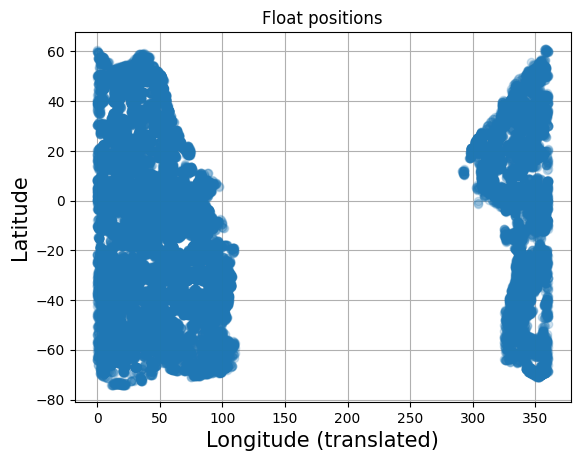

In [33]:
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

pdf = PdfPages("pca_py.pdf")
date = pd.to_datetime(date)
ddate = date - date.min()
day = [x.days for x in ddate]
lon_sin = np.sin(2*np.pi*lon/360)
lon_cos = np.cos(2*np.pi*lon/360)
cmean_lon = np.arctan2(lon_sin.mean(), lon_cos.mean()) * 360 / (2*np.pi)
# Convert latitude so that the Pacific ocean doesn't wrap
# around the origin.
lon = (lon + 60) % 360

# Create a matrix of observed variables that describe
# the location and time at which each profile was
# obtained.
n = len(lat)
Y = np.zeros((n, 3))
Y[:, 0] = lat
Y[:, 1] = lon
Y[:, 2] = day

plt.clf()
plt.grid(True)
plt.plot(lon, lat, "o", rasterized=True, alpha=0.2)
plt.xlabel("Longitude (translated)", size=15)
plt.ylabel("Latitude", size=15)
plt.title("Float positions")
pdf.savefig()

In [34]:
def get_pcs(x):
    xc = x.copy()
    xm = x.mean(1)
    for j in range(x.shape[0]):
        xc[j, :] = x[j, :] - xm[j]
    cc = np.cov(xc)
    pcw, pcv = np.linalg.eigh(cc)

    # Reorder the PC's so that the dominant factors
    # are first.
    ii = np.argsort(pcw)[::-1]
    pcw = pcw[ii]
    pcv = pcv[:, ii]

    # For interpretability flip the PC's that are
    # mostly negative.
    for j in range(pcv.shape[1]):
        if (pcv[:, j] < 0).sum() > (pcv[:, j] >= 0).sum():
            pcv[:, j] *= -1

    # Get the PC scores for temperature
    scores = np.dot(xc.T, pcv[:, 0:5])

    return xm, pcw, pcv, scores

In [35]:
def pcplot(j, mean, pcv, scores, label):

    # Plot the mean profile
    plt.clf()
    plt.grid(True)
    plt.plot(pressure, mean)
    plt.gca().set_xlabel("Pressure", size=15)
    plt.gca().set_ylabel("Mean %s" % label, size=15)
    pdf.savefig()

    # Plot the PC loadings
    fn = ["Latitude", "Longitude", "Day"]
    plt.clf()
    plt.grid(True)
    plt.plot(pressure, pcv[:, j])
    plt.gca().set_xlabel("Pressure", size=15)
    plt.gca().set_ylabel("%s PC %d loading" % (label.title(), j + 1), size=15)
    if pcv[:, j].min() > 0:
        plt.gca().set_ylim(ymin=0)
    pdf.savefig()

    # Plot the mean +/- 1 SD of the loading pattern
    plt.clf()
    plt.title(label.title())
    plt.grid(True)
    s = scores[:, j].std()
    for f in [-1, 0, 1]:
        plt.plot(pressure, mean + f*s*pcv[:, j], color={-1: "blue", 0: "black", 1: "red"}[f])
    plt.gca().set_xlabel("Pressure", size=15)
    plt.gca().set_ylabel("Mean %s +/- PC %d loading" % (label, j + 1), size=15)
    pdf.savefig()

    # Plot the conditional mean PC score against an observed variable,
    # showing the conditional mean plus/minus one absolute deviation.
    for k in range(3):
        xx = np.linspace(Y[:, k].min(), Y[:, k].max(), 100)
        m = lowess(scores[:, j], Y[:, k], delta=0.01*np.ptp(Y[:, k]))
        resid = scores[:, j] - m[:, 1]
        r = lowess(np.abs(resid), Y[:, k], delta=0.01*np.ptp(Y[:, k]))
        yy = interp1d(m[:, 0], m[:, 1])(xx)
        yr = interp1d(r[:, 0], r[:, 1])(xx)
        f = 2
        ymx = (yy + f*yr).max()
        ymn = (yy - f*yr).min()
        plt.clf()
        plt.grid(True)
        plt.plot(xx, yy, "-", color="red")
        plt.plot(xx, yy-f*yr, "-", color="grey")
        plt.plot(xx, yy+f*yr, "-", color="grey")
        plt.gca().set_ylim([ymn, ymx])
        plt.gca().set_xlabel(fn[k], size=15)
        plt.gca().set_ylabel("%s PC %d score" % (label.title(), j + 1), size=15)
        pdf.savefig()

tempmean, tempw, tempv, tempscores = get_pcs(temp)
psalmean, psalw, psalv, psalscores = get_pcs(psal)

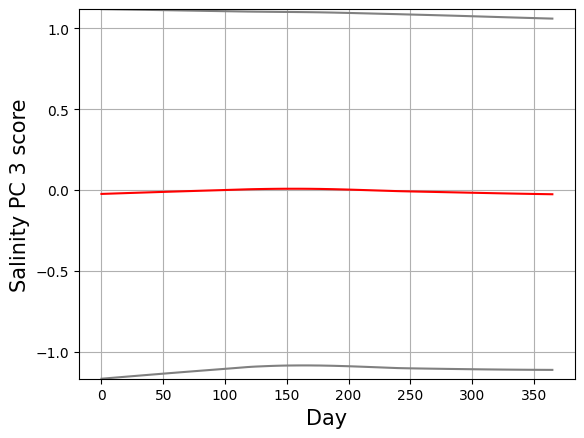

In [36]:
for j in range(3):
    pcplot(j, tempmean, tempv, tempscores, "temperature")

for j in range(3):
    pcplot(j, psalmean, psalv, psalscores, "salinity")

In [37]:
def my_cca(X, Y):
    n = X.shape[0]
    X = X - X.mean(0)
    Y = Y - Y.mean(0)
    Sx = np.dot(X.T, X) / n
    Sy = np.dot(Y.T, Y) / n
    Sxy = np.dot(X.T, Y) / n
    Rx = np.linalg.cholesky(Sx)
    Ry = np.linalg.cholesky(Sy)
    M = np.linalg.solve(Rx, Sxy)
    M = np.linalg.solve(Ry, M.T).T
    u, s, vt = np.linalg.svd(M)
    v = vt.T
    u = np.linalg.solve(Rx.T, u)
    v = np.linalg.solve(Ry.T, v)
    return u, v, s


# Standard CCA, due to the high dimensionality and consequent
# overfitting, the results make little sense.
X = temp.T.copy()
X -= X.mean(0)
Y = psal.T.copy()
Y -= Y.mean(0)
xc, yc, r = my_cca(X, Y)

In [38]:
# Flip the CCA components as needed for interpretability
def flip(xc, yc):
    for j in range(xc.shape[1]):
        if (xc[:, j] > 0).mean() + (yc[:, j] > 0).mean() < 1:
            xc[:, j] *= -1
            yc[:, j] *= -1
    return xc, yc

# The columns of ux and uy are the PC's of the temperature and salinity data.
ux,sx,vtx = np.linalg.svd(X, 0)
uy,sy,vty = np.linalg.svd(Y, 0)

0.2274581989783364
0.8105025244447843
0.9251029096255413
0.9476718033656963
0.9488832522394224
0.9512858111853679


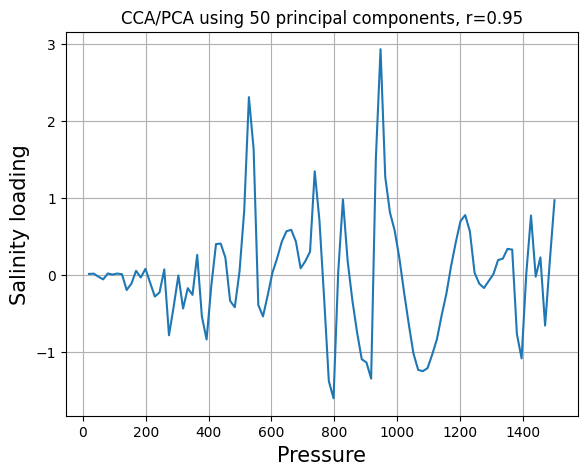

In [39]:
for q in [1, 2, 5, 10, 20, 50]:

    # Do CCA after projecting the profiles to the top q PC's.
    xc, yc, r = my_cca(ux[:, 0:q], uy[:, 0:q])

    # Map the loadings back to the original coordinates
    xc1 = np.dot(vtx.T[:, 0:q], np.linalg.solve(np.diag(sx[0:q]), xc))
    yc1 = np.dot(vty.T[:, 0:q], np.linalg.solve(np.diag(sy[0:q]), yc))
    xc1, yc1 = flip(xc1, yc1)

    # Plot the temperature loadings
    plt.clf()
    plt.axes([0.15, 0.1, 0.8, 0.8])
    plt.grid(True)
    plt.title("CCA/PCA using %d principal components, r=%.2f" % (q, r[0]))
    plt.plot(pressure, xc1[:, 0])
    if xc1[:, 0].min() > 0:
        plt.ylim(ymin=0)
    plt.xlabel("Pressure", size=15)
    plt.ylabel("Temperature loading", size=15)
    pdf.savefig()

    # Plot the salinity loadings
    plt.clf()
    plt.axes([0.15, 0.1, 0.8, 0.8])
    plt.title("CCA/PCA using %d principal components, r=%.2f" % (q, r[0]))
    plt.grid(True)
    plt.plot(pressure, yc1[:, 0])
    if yc1[:, 0].min() >= 0:
        plt.ylim(ymin=0)
    plt.xlabel("Pressure", size=15)
    plt.ylabel("Salinity loading", size=15)
    pdf.savefig()
    print(np.corrcoef(np.dot(X, xc1[:, 0]), np.dot(Y, yc1[:, 0]))[0,1])

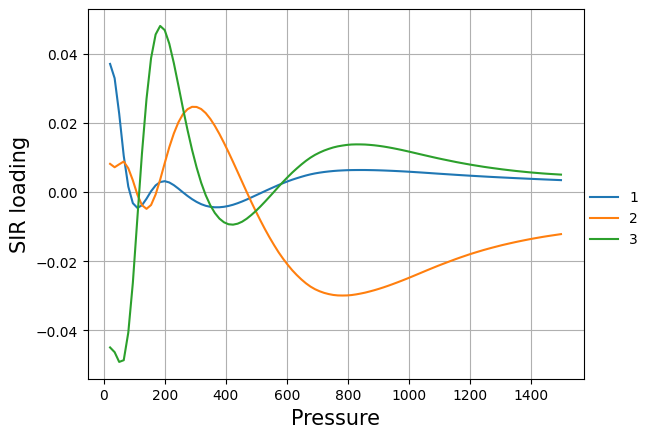

In [41]:
from statsmodels.regression.dimred import SIR
# Use Sliced Inverse Regression to predict latitude from the first
# q principal components of the temperature data.
q = 5
m = SIR(lat, ux[:, 0:q])
r = m.fit()
cf = np.dot(vtx.T[:, 0:q], np.linalg.solve(np.diag(sx[0:q]), r.params))

# Plot the SIR loadings.
plt.clf()
plt.grid(True)
for j in range(3):
    plt.plot(pressure, cf[:, j], "-", label="%d" % (j + 1))
ha, lb = plt.gca().get_legend_handles_labels()
leg = plt.figlegend(ha, lb, loc="center right")
leg.draw_frame(False)
plt.xlabel("Pressure", size=15)
plt.ylabel("SIR loading", size=15)
pdf.savefig()

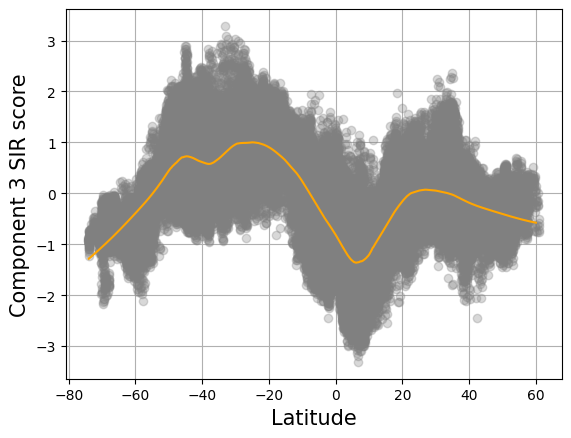

In [42]:
# Plot the SIR scores against latitude.
scores = np.dot(X, cf)
for j in range(3):
    plt.clf()
    plt.grid(True)
    plt.plot(lat, scores[:, j], "o", color="grey", alpha=0.3, rasterized=True)

    # Use lowess to estimate the conditional mean of the scores given latitude.
    # Lowess is slow and doesn't need all the data to give an accurate estimate.
    ii = np.random.choice(np.arange(scores.shape[0]), 2000, replace=False)
    m = lowess(scores[ii, j], lat[ii], frac=0.2)
    plt.plot(m[:, 0], m[:, 1], "-", color="orange")

    plt.xlabel("Latitude", size=15)
    plt.ylabel("Component %d SIR score" % (j + 1), size=15)
    pdf.savefig()

pdf.close()

In [43]:
def update_support(X, Y):
    N, p = Y.shape
    n, _ = X.shape
    XX = np.zeros((n, p))

    for i in range(n):
        Dx = X[i, :] - X
        DxN = np.linalg.norm(Dx, axis=1)
        DxN[i] = np.inf
        Dy = X[i, :] - Y
        DyN = np.linalg.norm(Dy, axis=1)
        q = (1/DyN).sum()
        XX[i, :] = np.dot(1/DxN, Dx) * (N / n)
        XX[i, :] += np.dot(1/DyN, Y)
        XX[i, :] /= q

    return XX

In [44]:
# Calculate N support points for the data in Y.  The points
# are stored in the rows of Y.
def support(Y, N, maxiter=1000):

    n, p = Y.shape
    X = np.random.normal(size=(N, p))

    for i in range(maxiter):
        X1 = update_support(X, Y)
        ee = np.linalg.norm(X1 - X)
        X = X1
        if ee < 1e-8:
            break

    return X

In [46]:
pdf = PdfPages("support_py.pdf")

def plot_support_map(ii, title):
    plt.clf()
    plt.figure(figsize=(7, 8))
    plt.axes([0.1, 0.1, 0.8, 0.8])
    m = Basemap(llcrnrlon=-100.,llcrnrlat=-65.,urcrnrlon=30.,urcrnrlat=80.,
                resolution='l',projection='merc', lat_0=0.,lon_0=0.)

    for j in range(ii.max() + 1):
        jj = np.flatnonzero(ii == j)
        x, y = m(lon[jj], lat[jj])
        plt.scatter(x, y, s=8, label=str(1+j))

    ha,lb = plt.gca().get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, "center right")
    leg.draw_frame(False)

    m.drawcoastlines()
    m.drawmapboundary()
    plt.title(title)
    pdf.savefig()

In [59]:
pdf = PdfPages("depth_py.pdf")

# Calculate the spatial depth of vector v relative
# to all columns of x.
def sdepth(v, x):
    p, n = x.shape
    z = x - v[:, None]
    zn = np.sqrt((z**2).sum(0))
    zn[np.abs(zn) < 1e-12] = np.inf
    z /= zn
    u = z.mean(1)
    return 1 - np.sqrt(np.sum(u**2))

In [60]:
def l2depth(v, x):
    p, n = x.shape
    z = x - v[:, None]
    zn = np.sqrt((z**2).sum(0))
    d = zn.mean()
    return 1e6 / (1 + d)

In [61]:
def bdepth(v, x, m=500):
    p, n = x.shape
    t = 0.0
    for k in range(m):
        ii = np.random.choice(n, 3, replace=False)
        z = x[:, ii]
        mn = z.min(1)
        mx = z.max(1)
        t += np.mean((v >= mn) & (v <= mx))
    t /= m
    return t

In [62]:
def depths(x, dfun, progress=False):
    p, n = x.shape
    d = np.zeros(n)
    for i in range(n):
        if progress and (i % 200 == 0):
            print(i, end="", flush=True)
            print(".", end="", flush=True)
        d[i] = dfun(x[:, i], x)
    if progress:
        print("done", flush=True)
    return d

In [63]:
def depth_cut(dp, x, q, pressure, ylab):
    dq = pd.qcut(dp, q)
    for (i,iv) in enumerate(dq.categories):
        ii = np.flatnonzero(dq == iv)
        jj = np.random.choice(ii, 10)

        plt.clf()
        plt.figure(figsize=(6.4,4.8))
        plt.grid(True)
        plt.title("Depth quantile %d %s" % (i + 1, str(iv)))
        for j in jj:
            plt.plot(pressure, x[:, j], "-", color="grey")
        plt.ylabel(ylab, size=15)
        plt.xlabel("Pressure", size=15)
        pdf.savefig()

In [67]:
ii = np.random.choice(np.arange(temp.shape[1]), 5000, replace=False)
tempx = temp[:, ii]
psalx = psal[:, ii]
latx = lat[ii]
lonx = lon[ii]
dp_temp = depths(tempx, sdepth, progress=True)
dp_psal = depths(psalx, sdepth, progress=True)

0.200.400.600.800.1000.1200.1400.1600.1800.2000.2200.2400.2600.2800.3000.3200.3400.3600.3800.4000.4200.4400.4600.4800.done
0.200.400.600.800.1000.1200.1400.1600.1800.2000.2200.2400.2600.2800.3000.3200.3400.3600.3800.4000.4200.4400.4600.4800.done


/var/folders/81/fr266crd1kq7t91jpmw9n7qm0000gn/T/ipykernel_75708/4277871734.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6.4,4.8))


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

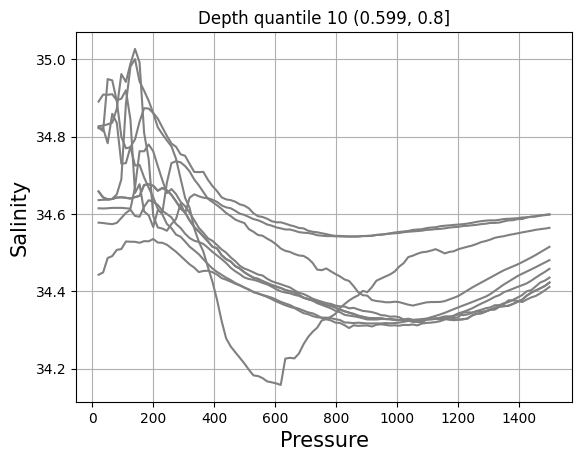

In [68]:
q = 10
depth_cut(dp_temp, tempx, q, pressure, "Temperature")
depth_cut(dp_psal, psalx, q, pressure, "Salinity")

In [69]:
def depth_correlates(dp, lat, lon, day, title, f=2):
    dpx = pd.DataFrame({"depth": dp, "lat": lat, "lon": lon, "day": day})
    vn = {"lat": "Latitude", "lon": "Longitude", "day": "Day"}
    for v in ["lat", "lon", "day"]:

        # A grid of 100 values covering the range of the
        # explanatory variable.
        xx = np.linspace(dpx[v].min(), dpx[v].max(), 100)

        # Use loess to regress depth on the explanatory variable
        m = lowess(dpx["depth"], dpx[v])
        dh = interp1d(m[:, 0], m[:, 1])(xx)

        # Use loess to regress the absolute depth residuals
        # on the explanatory variable
        aresid = np.abs(m[:, 1] - dpx["depth"])
        r = lowess(aresid, dpx[v])
        dq = interp1d(r[:, 0], r[:, 1])(xx)

        plt.clf()
        plt.title(title)
        plt.grid(True)
        plt.plot(xx, dh, "-")
        plt.fill_between(xx, dh-f*dq, dh+f*dq, color="grey", alpha=0.5)
        plt.xlabel(vn[v], size=15)
        plt.ylabel("Depth", size=15)
        pdf.savefig()